### Marco Sasso - Reti Data Science

# Successful Crowdfunding Evaluation
## Applicazione di algoritmi di classificazione supervisionati per la valutazione di campagne di crowdfunding all'interno della piattaforma Kickstarter



### Indice
* [1. La piattaforma Kickstarter](#section1)<a href='section1'></a>
* [2. Obiettivo del progetto](#section2)<a href='section2'></a>
* [3. Esplorazione del dataset](#section3)<a href='section3'></a>
* [4. Costruzione del dataset per i modelli di Machine Learning](#section4)<a href='section4'></a>
* [5. Training e Test dei modelli di Machine Learning](#section5)<a href='section5'></a>


<a id='section1'></a>
### 1. La piattaforma Kickstarter
Fondato ad aprile 2009 da Perry Chen, Yancey Strickler e Charles Adler, Kickstarter è un sito web americano il cui è scopo è porsi come intermediario all'interno di operazioni di finanziamento collettivo per progetti creativi (il cosiddetto "Crowdfunding"), facilitando l'incontro tra domanda e offerta di capitali.

All'interno della piattaforma, i creatori di un progetto fissano un target minimo di raccolta (o "Goal", come si vedrà in seguito) e una data di scadenza per la campagna di crowdfunding. Se il target non viene raggiunto entro la scadenza, i fondi non vengono raccolti da chi ha promosso il progetto.
Il finanziamento di un progetto, all'interno di Kickstarter, è inteso unicamente come "supporto" allo spirito di iniziativa dei creatori. Gli investitori, infatti, non traggono benefici in denaro dalla riuscita di un progetto, ma vengono ricompensati con altri tipi di prodotti e/o esperienze come incontri con i creatori, possibilità di prova in anteprima dei prodotti, magliette personalizzate ecc.

In 10 anni di esistenza, secondo i dati aggiornati a maggio 2019, su Kickstarter sono stati raccolti più di 4 miliardi di dollari da più di 16 milioni di investitori, che hanno portato a finanziare circa 445.000 progetti riguardanti film, musica, fumetti, giornalismo, videogames ecc.

<a id='section2'></a>
### 2. Obiettivo del progetto
L'obiettivo di questo progetto è creare dei modelli in grado di valutare ex-ante l'esito della campagna di crowdfunding di un progetto applicando alcuni algoritmi di classificazione supervisionati.

A questo scopo, si è utilizzato un dataset scaricato dalla piattaforma Kaggle (https://www.kaggle.com/kemical/kickstarter-projects) che, opportunamente elaborato, è stato fornito come input per la costruzione di modelli di predizione secondo le metodologie che verranno descritte nei capitoli successivi.

<a id='section3'></a>
### 3. Esplorazione del dataset
Importo le librerie Python necessarie al funzionamento del codice:

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import sklearn.metrics as metrics
import time
import seaborn as sns
import math
import matplotlib.pyplot as plt
import statistics

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

Ora è possibile importare il dataset dei progetti Kickstarter all'interno di un DataFrame Pandas. Creo due copie inizialmente identiche del dataset: **dataTBA** (To Be Analyzed) e **dataML** (Machine Learning) utilizzati, rispettivamente, per l'analisi iniziale dei dati a disposizione e per il train/test degli algoritmi di classificazione: 

In [3]:
dataset = pd.read_csv('KickStarterProjects.csv') # dataset originario
dataTBA = dataset.copy() # dataset per analisi preliminari
dataML = dataTBA.copy() # dataset per train e test dei modelli di Machine Learning

Controllo quanti record, ossia progetti, contiene il dataset e quante features sono associate a ciascuno di esso

In [4]:
print('Il dataset contiene', dataTBA.shape[0], 'record e', dataTBA.shape[1], 'features')

Il dataset contiene 378661 record e 15 features


Il dataset è inizialmente strutturato in questa maniera:

In [5]:
dataTBA.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


Come si nota dall'anteprima, le features associate a ciascun progetto sono le seguenti:

In [6]:
dataTBA.dtypes

ID                    int64
name                 object
category             object
main_category        object
currency             object
deadline             object
goal                float64
launched             object
pledged             float64
state                object
backers               int64
country              object
usd pledged         float64
usd_pledged_real    float64
usd_goal_real       float64
dtype: object

1. **ID** = codice identificativo del progetto all'interno del dataset
2. **name** = nome del progetto
3. **category** = sottocategoria/settore del progetto
4. **main_category** = macrocategoria/settore del progetto
5. **currency** = valuta in cui è denominato il target di raccolta del progetto
6. **deadline** = data di fine della campagna di crowdfunding
7. **goal** = target di raccolta del progetto
8. **launched** = data di lancio della campagna di crowdfunding
9. **pledged** = ammontare della raccolta durante la campagna di crowdfunding
10. **state** = esito della campagna di crowdfunding
11. **backers** = numero di finanziatori del progetto
12. **country** = paese in cui è stato lanciato il progetto
13. **usd pledged** = ammontare di raccolta dei progetti originariamente denominati in dollari
14. **usd_pledged_real** = ammontare di raccolta dei progetti convertiti in dollari (dove necessario)

Per ciascuno di questi campi, osserviamo quanti record presentano valori mancanti:

In [7]:
dataTBA.isnull().sum()

ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64

Possiamo ritenerci piuttosto fortunati per quanto riguarda la gestione dei missing values: solo 4 progetti in totale non presentano un nome, mentre per quasi 4000 di essi non è indicato il valore nel campo *usd_pledged*, dato che non tutti i target di raccolta (Goal) sono denominati in dollari. Tuttavia, per ogni progetto contenuto nel dataset è presente il campo *usd_pledged_real*, convertito in dollari dalla local currency dove necessario.

A questo punto è utile indagare sui valori assunti da alcune delle principali features che verranno usate come input per addestrare i modelli di classificazione. Poiché l'obiettivo del progetto è valutare l'esito delle campagne di crowdfunding, osserviamo come sono distribuiti i valori presenti all'interno della colonna "state"

In [8]:
dataTBA['state'].value_counts()/dataTBA['state'].count()

failed        0.522153
successful    0.353762
canceled      0.102411
undefined     0.009407
live          0.007392
suspended     0.004875
Name: state, dtype: float64

e plottiamo con un grafico a barre i valori

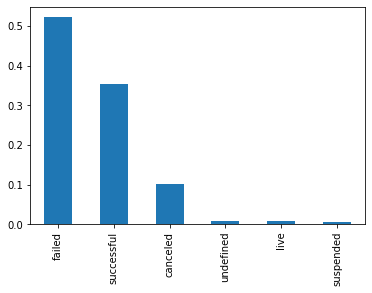

In [9]:
(dataTBA['state'].value_counts()/dataTBA['state'].count()).plot.bar()

Il 52% dei progetti ha fallito nel raggiungimento del target di raccolta (*Failed*), circa il 35% è riuscito nell'intento (*Successful*), mentre il 10% di essi è stato rimosso preventivamente dai creatori (*Canceled*). Il resto si divide tra progetti dall'esito indefinito (*Undefined*), in corso (*Live*) e sospesi per violazione del regolamento della piattaforma Kickstarter (*Suspended*). Come si vedrà anche nella parte di costruzione del dataset per il training dei modelli, per l'esperimento ci si concentrerà esclusivamente sui progetti che hanno riportato esiti *Successful* e *Failed*.

Un'altra feature interessante del dataset è la valuta (*currency*) di denominazione del target di raccolta (*Goal*).

In [10]:
dataTBA['currency'].value_counts()/dataTBA['currency'].count()

USD    0.780025
GBP    0.090139
EUR    0.045965
CAD    0.039513
AUD    0.020995
SEK    0.004722
MXN    0.004627
NZD    0.003895
DKK    0.002982
CHF    0.002028
NOK    0.001907
HKD    0.001632
SGD    0.001466
JPY    0.000106
Name: currency, dtype: float64

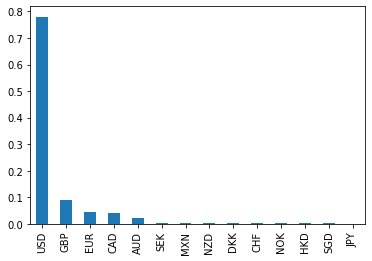

In [11]:
(dataTBA['currency'].value_counts()/dataTBA['currency'].count()).plot.bar()

Quasi l'80% dei progetti del dataset presenta un obiettivo espresso in dollari statunitensi (USD), e più del 95% dei *Goal* è espresso tra dollari USA (USD), sterline (GBP), euro (EUR), dollari canadesi (CAD) e dollari australiani (AUD).

Di seguito, invece, il conteggio dei progetti divisi per ciascuna macro-categoria (*main_category*):

In [12]:
dataTBA['main_category'].value_counts()

Film & Video    63585
Music           51918
Publishing      39874
Games           35231
Technology      32569
Design          30070
Art             28153
Food            24602
Fashion         22816
Theater         10913
Comics          10819
Photography     10779
Crafts           8809
Journalism       4755
Dance            3768
Name: main_category, dtype: int64

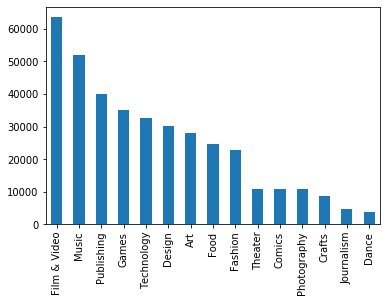

In [13]:
dataTBA['main_category'].value_counts().plot.bar()

All'interno delle 15 *main_category* presenti nel dataset, osserviamo ora la proporzione tra progetti che hanno raggiunto l'obiettivo di raccolta prefissato (*Successful*) e quanti invece hanno fallito (*Failed*).

state          successful   failed  highSuccess
main_category                                  
Art               11510.0  14131.0            0
Comics             5842.0   4036.0            1
Crafts             2115.0   5703.0            0
Dance              2338.0   1235.0            1
Design            10550.0  14814.0            0
Fashion            5593.0  14182.0            0
Film & Video      23623.0  32904.0            0
Food               6085.0  15969.0            0
Games             12518.0  16003.0            0
Journalism         1012.0   3137.0            0
Music             24197.0  21752.0            1
Photography        3305.0   6384.0            0
Publishing        12300.0  23145.0            0
Technology         6434.0  20616.0            0
Theater            6534.0   3708.0            1

In 4 main_category su 15 il numero di progetti che hanno raggiunto il Goal è superiore rispetto a quelli che non lo hanno raggiunto


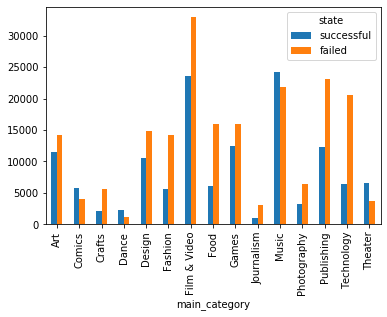

In [14]:
# creo la tabella pivot che ha come righe le main_category e come colonne i possibili esiti (state) dei progetti
stateByMainCat = dataTBA.pivot_table(index = 'main_category', columns = dataTBA.state, values = 'state', aggfunc = 'count')

# creo una colonna nella quale inserisco 1 se il numero di progetti di successo è maggiore di quelli falliti, altrimenti 0
stateByMainCat['highSuccess'] = np.where(stateByMainCat['successful'] > stateByMainCat['failed'], 1, 0)

# seleziono e stampo le colonne sui progetti con esiti successful e failed, trascurando quelli con altri esiti
print(stateByMainCat.loc[:, ['successful', 'failed', 'highSuccess']])

# plotto i risultati
stateByMainCat.loc[:, ['successful', 'failed']].plot.bar()

print('\nIn', stateByMainCat['highSuccess'].sum(), 'main_category su', stateByMainCat['highSuccess'].count(), 
      'il numero di progetti che hanno raggiunto il Goal è superiore rispetto a quelli che non lo hanno raggiunto')

In tutti i progetti presenti nel dataset, solo nelle *main_category* Comics, Dance, Music e Theater il numero di progetti che hanno raggiunto il Goal è superiore a quello dei progetti che non lo hanno raggiunto.

A questo punto, ci concentriamo sulla distribuzione dei *Goal* dei vari progetti contenuti nel dataset, plottando l'istrogramma dei valori contenuti nella feature "usd_goal_real":

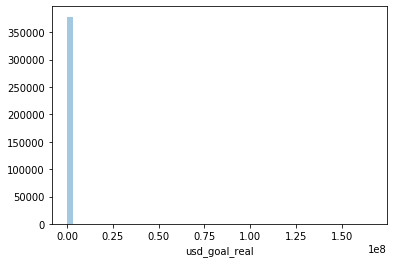

In [15]:
#dataTBA['usd_goal_real'].plot.hist()
sns.distplot(dataTBA['usd_goal_real'], kde = False)

La distribuzione dei *Goal* presenta un'asimmetria fortemente positiva: quasi la totalità dei progetti ha un valore di *Goal* compreso tra 0 e 250.000 USD, con la presenza di alcuni outliers come si vede dal Box & Whisker qui sotto

{'whiskers': [<matplotlib.lines.Line2D at 0x1c2f962a0f0>,
 'caps': [<matplotlib.lines.Line2D at 0x1c2f962a7f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c2f6a49c18>],
 'medians': [<matplotlib.lines.Line2D at 0x1c2f962ae80>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c2f9633208>],
 'means': []}

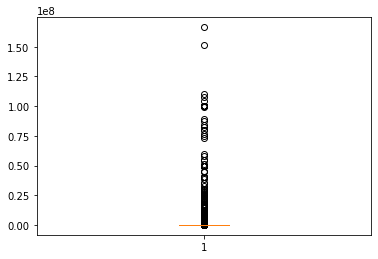

In [16]:
plt.boxplot(dataTBA['usd_goal_real'])

Per migliorare leggermente la visualizzazione dei dati, effettuo gli stessi plot filtrando i progetti con un *Goal* inferiore a 100.000 USD

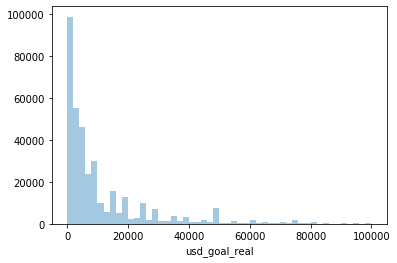

In [17]:
sns.distplot(dataTBA[dataTBA['usd_goal_real'] < 100000]['usd_goal_real'], kde = False)

{'whiskers': [<matplotlib.lines.Line2D at 0x1c2fc4f6f98>,
 'caps': [<matplotlib.lines.Line2D at 0x1c2fc5036d8>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c2fc4f6e48>],
 'medians': [<matplotlib.lines.Line2D at 0x1c2fc503d68>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c2fc50d0f0>],
 'means': []}

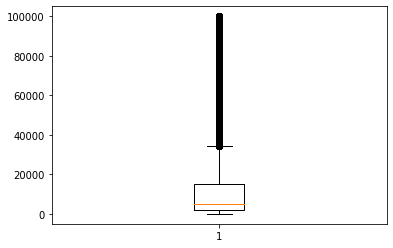

In [18]:
plt.boxplot(dataTBA[dataTBA['usd_goal_real'] < 100000]['usd_goal_real'])

A questo punto calcolo il target di raccolta medio per ciascuna *main_category*, un'altra feature che sarà inclusa nel training dei modelli di classificazione:

In [19]:
meanGoalByMainCat = pd.DataFrame(dataTBA.groupby('main_category')['usd_goal_real'].mean())
meanGoalByMainCat.columns = ['Mean Goal']
meanGoalByMainCat

,Mean Goal
main_category,
Art,39198.575879
Comics,19571.430669
Crafts,10434.466228
Dance,9588.328548
Design,41871.388591
Fashion,22412.409361
Film & Video,82625.292254
Food,49039.620804
Games,44923.741408


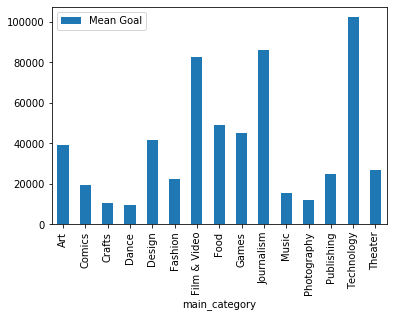

In [20]:
 meanGoalByMainCat.plot.bar()

Infine, ci concentriamo sulla durata delle campagne di crowdfunding che, per ogni progetto, equivale alla differenza tra le feature *Deadline* e *Launched*. Per il calcolo, converto in formato datetime le due features, eseguo la differenza e, tramite la manipolazione di stringhe, ricavo la durata in giorni.

{'whiskers': [<matplotlib.lines.Line2D at 0x1c2f68f5198>,
 'caps': [<matplotlib.lines.Line2D at 0x1c2f19a1ac8>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c2f68f5e48>],
 'medians': [<matplotlib.lines.Line2D at 0x1c2f6904f60>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c2f69047b8>],
 'means': []}

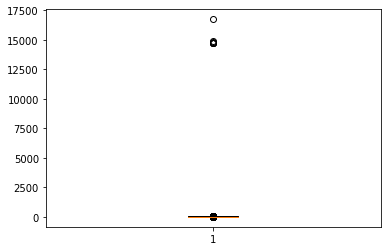

In [21]:
# converto le features in formato datetime
dataTBA['dtLaunched'] = pd.to_datetime(dataTBA.launched)          
dataTBA['dtDeadline'] = pd.to_datetime(dataTBA.deadline)

# calcolo la lunghezza della campagna di crowdfunding in formato datetime
dataTBA['cfLen'] = dataTBA['dtDeadline'] - dataTBA['dtLaunched']

# ricavo la lunghezza della campagna in giorni eseguendo lo split della stringa
dataTBA['cfLen'] = dataTBA['cfLen'].apply(lambda rowConv: int(str(rowConv).split()[0]))

#plotto il Box & Whisker delle durate dei giorni
plt.boxplot(dataTBA['cfLen'])

Il grafico suggerisce la presenza di alcuni outliers, con una durata della campagna di crowdfunding di oltre 12000 giorni (più di 32 anni!). Eseguo nuovamente il plot fissando una soglia massima arbitraria di 1000 giorni:

{'whiskers': [<matplotlib.lines.Line2D at 0x1c2f19fc320>,
 'caps': [<matplotlib.lines.Line2D at 0x1c2f19fca20>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c2f19fc1d0>],
 'medians': [<matplotlib.lines.Line2D at 0x1c2f19ea0f0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c2f19ea438>],
 'means': []}

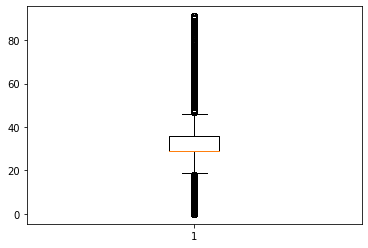

In [22]:
plt.boxplot(dataTBA[dataTBA['cfLen'] < 1000]['cfLen'])

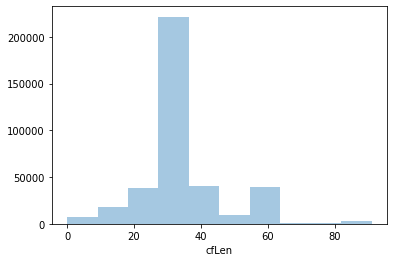

In [23]:
sns.distplot(dataTBA[dataTBA['cfLen'] < 1000]['cfLen'], kde = False, bins = 10)

<a id='section4'></a>
### 4. Costruzione del dataset per i modelli di Machine Learning

Dopo aver esaminato alcune delle principali feature che compongono il dataset originario, in questa sezione si andrà a costruire un nuovo dataset contenente delle features "derivate" che saranno prese in input dai modelli di classificazione supervisionati.

Per fare ciò, mi domando quali possano essere dei possibili fattori esplicativi dell'esito di un progetto e ricavo dal dataset i relativi valori che utilizzerò nel capitolo successivo per addestrare i modelli:

* 1) la durata della campagna di crowdfunding influenza l'esito del progetto? --> tramite le colonne *launched* e *deadline* ricavo la durata della campagna di crowdfunding espressa in giorni;
* 2) il periodo di lancio influenza l'esito del progetto? --> dalla colonna *launched* ricavo:
    * mese di lancio;
    * settimana di lancio;
    * giorno della settimana di lancio;
    * eventuale lancio durante un weekend;
* 3) l'appartenenza ad una macro-categoria influenza l'esito del progetto? --> tramite la colonna *main_category* ricavo:
    * *goal* medio all'interno della macro-categoria;
    * numero di progetti lanciati nella macro-categoria;
    * deviazione del *goal* del progetto dalla media della macro-categoria;
* 4) l'appartenenza ad una sotto-categoria influenza l'esito del progetto? --> tramite la colonna *category* ricavo:
    * *goal* medio all'interno della sotto-categoria;
    * numero di progetti lanciati nella sotto-categoria;
    * deviazione del *goal* del progetto dalla media della sotto-categoria;
* 5) la composizione del nome del progetto influenza l'esito del progetto? --> dalla colonna *name* ricavo il numero di parole che compongono il nome del progetto
    
Ipotizzate le potenziali caratteristiche "chiave" di un progetto, costruisco il dataset per il training e i test dei modelli, applicando inizialmente due filtri al dataframe **dataML**. Il primo filtro consiste nella selezione dei soli progetti caratterizzati dalle label *successful* e *failed* all'interno della colonna *state*, così da rimuovere dal dataset quei record che presentano un esito "intermedio"; il secondo filtro riguarda l'eliminazione degli outliers con una durata anomala della campagna di crowdfunding, già rilevati al termine del capitolo precedente.

In [55]:
dataML = dataset.copy()

# filtro i progetti riusciti e falliti sulla base della colonna "state" del dataset
dataML = dataML[dataML.state.isin(['successful', 'failed'])]

# calcolo la durata della campagna di crowdfunding di ciascun progetto come nel capitolo precedente
dataML['dtLaunched'] = pd.to_datetime(dataML.launched)          
dataML['dtDeadline'] = pd.to_datetime(dataML.deadline)

dataML['cfLen'] = dataML['dtDeadline'] - dataML['dtLaunched'] # lunghezza della campagna di crowdfunding in formato datetime
dataML['cfLen'] = dataML['cfLen'].apply(lambda rowConv: int(str(rowConv).split()[0])) # lunghezza della campagna in giorni

# rimuovo gli outlier sulla base della durata del crowdfunding
dataML = dataML[dataML['cfLen'] < 1000]

Dopo i primi due filtri sui dati, il dataset appare in questo modo

In [56]:
dataML.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,dtLaunched,dtDeadline,cfLen
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95,2015-08-11 12:12:28,2015-10-09,58
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00,2017-09-02 04:43:57,2017-11-01,59
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00,2013-01-12 00:20:50,2013-02-26,44
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00,2012-03-17 03:24:11,2012-04-16,29
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.0,successful,224,US,52375.0,52375.0,50000.00,2016-02-26 13:38:27,2016-04-01,34


Controllo l'eventuale presenza di missing values e calcolo l'attuale dimensione del dataset

In [57]:
dataML.isnull().sum()

ID                    0
name                  3
category              0
main_category         0
currency              0
deadline              0
goal                  0
launched              0
pledged               0
state                 0
backers               0
country               0
usd pledged         210
usd_pledged_real      0
usd_goal_real         0
dtLaunched            0
dtDeadline            0
cfLen                 0
dtype: int64

In [58]:
n_record = dataML.shape[0]
print('Il dataset contiene', n_record, 'record')

Il dataset contiene 331675 record


Un'altra feature che sarà utilizzata nell'addestramento dei modelli, come anticipato a inizio capitolo, riguarda il numero di parole che compongono il nome del progetto. Poiché tre di essi presentano un valore nullo nel nome, elimino i relativi record:

In [59]:
dataML = dataML.dropna(subset = ['name'])
print('Sono stati eliminati', n_record - dataML.shape[0], 'record. Ora il dataset contiene', dataML.shape[0], 'record')

Sono stati eliminati 3 record. Ora il dataset contiene 331672 record


In [60]:
dataML.isnull().sum()

ID                    0
name                  0
category              0
main_category         0
currency              0
deadline              0
goal                  0
launched              0
pledged               0
state                 0
backers               0
country               0
usd pledged         210
usd_pledged_real      0
usd_goal_real         0
dtLaunched            0
dtDeadline            0
cfLen                 0
dtype: int64

Al momento ignoro volutamente i missing values nella colonna *usd pledged*, che verrà rimossa negli step successivi.

Tornando alla creazione delle feature derivate, dalla data di lancio precedentemente convertita in formato datetime ricavo il mese, la settimana e il giorno della settimana (da lunedì a venerdì) del lancio del progetto.

In [61]:
# mese
dataML['launchedMonth'] = dataML['dtLaunched'].apply(lambda data: data.month)

# settimana
dataML['launchedWeek'] = dataML['dtLaunched'].apply(lambda data: data.week)      

# giorno della settimana (output: 0 = lunedì, 6 = domenica)
dataML['launchedDay'] = dataML['dtLaunched'].apply(lambda data: data.weekday())

# il progetto è stato lanciato nel weekend? Se sì 1, altrimenti 0
dataML['isWeekend'] = dataML['launchedDay'].apply(lambda day: 1 if day > 4 else 0)

In [62]:
dataML.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,...,usd pledged,usd_pledged_real,usd_goal_real,dtLaunched,dtDeadline,cfLen,launchedMonth,launchedWeek,launchedDay,isWeekend
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,...,0.0,0.0,1533.95,2015-08-11 12:12:28,2015-10-09,58,8,33,1,0
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,...,100.0,2421.0,30000.00,2017-09-02 04:43:57,2017-11-01,59,9,35,5,1
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,...,220.0,220.0,45000.00,2013-01-12 00:20:50,2013-02-26,44,1,2,5,1
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,...,1.0,1.0,5000.00,2012-03-17 03:24:11,2012-04-16,29,3,11,5,1
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.0,successful,...,52375.0,52375.0,50000.00,2016-02-26 13:38:27,2016-04-01,34,2,8,4,0


Terminata la derivazione delle features riguardanti il periodo di lancio del progetto, ricavo ora le features che derivano dall'appartenenza di ciascun progetto a una macro-categoria (*main_category*) e sotto-categoria (*category*).
Ricavo per ciascuna *main_category* e *category* il valore di *goal* medio e il numero di progetti, e associo questi valori ad ogni singolo progetto in base al gruppo di appartenenza. Infine, per ogni progetto calcolo la deviazione del target di raccolta *goal* da quello medio di *main_category* e *category*.

In [63]:
# aggrego i progetti per main_category e category e ne calcolo goal medio e numerosità 
subDataMainCategory = dataML.groupby('main_category').agg({'usd_goal_real': 'mean', 'category': 'count'})
subDataCategory = dataML.groupby('category').agg({'usd_goal_real': 'mean', 'main_category': 'count'})

# rinomino le colonne dei due dataframe
subDataMainCategory.columns = ['mainCategoryMeanGoal', 'mainCategoryCount']
subDataCategory.columns = ['CategoryMeanGoal', 'CategoryCount']

# unisco i due dataframe a dataML, così da associare ad ogni progetto il goal medio e il numero di progetti 
#della main_category e category di appartenenza
dataML = dataML.merge(subDataMainCategory, on = 'main_category')
dataML = dataML.merge(subDataCategory, on = 'category')

# per ogni progetto, calcolo la distanza del target di raccolta da quella media di main_category e category di appartenenza
dataML['devFromMainCatGoal'] = dataML['mainCategoryMeanGoal'] - dataML['usd_goal_real']
dataML['devFromCatGoal'] = dataML['CategoryMeanGoal'] - dataML['usd_goal_real']

dataML.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,...,launchedMonth,launchedWeek,launchedDay,isWeekend,mainCategoryMeanGoal,mainCategoryCount,CategoryMeanGoal,CategoryCount,devFromMainCatGoal,devFromCatGoal
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,...,8,33,1,0,17543.917732,35445,4969.590554,1246,16009.967732,3435.640554
1,1001028167,Steel Cathedrals- Short poems for the digital ...,Poetry,Publishing,GBP,2013-07-28,4000.0,2013-06-28 23:17:04,20.0,failed,...,6,26,4,0,17543.917732,35445,4969.590554,1246,11482.947732,-1091.379446
2,1001468086,Bass River Press,Poetry,Publishing,USD,2015-04-05,2000.0,2015-03-06 19:58:58,325.0,failed,...,3,10,4,0,17543.917732,35445,4969.590554,1246,15543.917732,2969.590554
3,1001991458,Poems For Apostates & tales of a young Sciento...,Poetry,Publishing,USD,2014-05-31,10000.0,2014-05-01 17:47:49,101.0,failed,...,5,18,3,0,17543.917732,35445,4969.590554,1246,7543.917732,-5030.409446
4,1002519316,"Your poem, by me.",Poetry,Publishing,CAD,2015-10-31,1000.0,2015-10-01 20:00:32,55.0,failed,...,10,40,3,0,17543.917732,35445,4969.590554,1246,16786.397732,4212.070554


Associo a ciascun dataset delle variabili "dummy" per tenere traccia della *main_category* di appartenenza

In [64]:
# dummies per appartenenza a main_category
dataML = pd.concat([dataML, pd.get_dummies(dataML['main_category'])], axis = 1)

L'ultima feature utile per i modelli di classificazione, sulla base delle ipotesi fatte a inizio capitolo, consiste nel numero di parole che compongono il nome del progetto, che calcolo di seguito

In [65]:
# numero parole
dataML['numWords'] = dataML['name'].apply(lambda name: len(str(name).split()))

Elaboro le label associate agli esiti dei progetti indicati nella colonna *state*, identificando con 1 un progetto riuscito (*successful*) e 0 un progetto fallito (*failed*), salvandole in una variabile a parte.

In [66]:
# Ricavo le labels e le salvo nella variabile stateLabels
dataML['isSuccessful'] = dataML['state'].apply(lambda state: 1 if state == 'successful' else 0)
stateLabels = dataML['isSuccessful']

# rimuovo la colonna delle labels dal dataset di train
dataML = dataML.drop(['isSuccessful'], axis = 1)

# resetto gli indici del dataset
dataML = dataML.reset_index(drop = True)

dataML.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,...,Film & Video,Food,Games,Journalism,Music,Photography,Publishing,Technology,Theater,numWords
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,...,0,0,0,0,0,0,1,0,0,6
1,1001028167,Steel Cathedrals- Short poems for the digital ...,Poetry,Publishing,GBP,2013-07-28,4000.0,2013-06-28 23:17:04,20.0,failed,...,0,0,0,0,0,0,1,0,0,8
2,1001468086,Bass River Press,Poetry,Publishing,USD,2015-04-05,2000.0,2015-03-06 19:58:58,325.0,failed,...,0,0,0,0,0,0,1,0,0,3
3,1001991458,Poems For Apostates & tales of a young Sciento...,Poetry,Publishing,USD,2014-05-31,10000.0,2014-05-01 17:47:49,101.0,failed,...,0,0,0,0,0,0,1,0,0,9
4,1002519316,"Your poem, by me.",Poetry,Publishing,CAD,2015-10-31,1000.0,2015-10-01 20:00:32,55.0,failed,...,0,0,0,0,0,0,1,0,0,4


In [67]:
print('Il dataset ha', dataML.shape[1], 'colonne')

Il dataset ha 44 colonne


Ora non resta che determinare le features da rimuovere dal dataset *dataML*, così da mantenere solo quelle che saranno prese come input dagli algoritmi di classificazione

In [68]:
# definisco le features da rimuovere dal dataset ed elimino le relative colonne
featToDrop = ['ID', 'name', 'category', 'main_category', 'currency', 'deadline', 'goal', 'launched', 
              'pledged', 'state', 'backers', 'country', 'usd pledged', 'usd_pledged_real', 'dtLaunched',
              'dtDeadline']

dataML = dataML.drop(featToDrop, axis = 1)

In [69]:
dataML.head()

,usd_goal_real,cfLen,launchedMonth,launchedWeek,launchedDay,isWeekend,mainCategoryMeanGoal,mainCategoryCount,CategoryMeanGoal,CategoryCount,...,Film & Video,Food,Games,Journalism,Music,Photography,Publishing,Technology,Theater,numWords
0,1533.95,58,8,33,1,0,17543.917732,35445,4969.590554,1246,...,0,0,0,0,0,0,1,0,0,6
1,6060.97,29,6,26,4,0,17543.917732,35445,4969.590554,1246,...,0,0,0,0,0,0,1,0,0,8
2,2000.00,29,3,10,4,0,17543.917732,35445,4969.590554,1246,...,0,0,0,0,0,0,1,0,0,3
3,10000.00,29,5,18,3,0,17543.917732,35445,4969.590554,1246,...,0,0,0,0,0,0,1,0,0,9
4,757.52,29,10,40,3,0,17543.917732,35445,4969.590554,1246,...,0,0,0,0,0,0,1,0,0,4


<a id='section5'></a>
### 5. Training e Test dei modelli di Machine Learning

Per la predizione della label *state* che identifica l'esito di un progetto, testo 3 differenti modelli di classificazione supervisionati: 
* **Random Forest Classifier**;
* **K-Neighbors Classifier**;
* **Logistic Regression**

Effettuo uno scaling dei dati attraverso il *Robust Scaler* contenuto nella libreria sklearn.preprocessing importata all'inizio del notebook

In [70]:
scaler = RobustScaler()
dataML = scaler.fit_transform(dataML)

Splitto il dataset riservando l'80% per il training del modello e il 20% per il test


In [71]:
dataTrain, dataTest, labelTrain, labelTest = train_test_split(dataML, stateLabels, test_size = 0.2, random_state = 42)

Definisco una lista con i nomi degli algoritmi di classificazione che sarà utilizzata all'interno di un ciclo for per il training dei modelli in sequenza. Inoltre, creo un dataframe pandas all'interno del quale saranno salvati i parametri per la valutazione dei 3 modelli, ossia:
* **Accuracy (score) del modello out of sample**, applicato sulla porzione di dati destinata al test;
* **Accuracy (score) del modello in sample**, applicato sugli stessi dati usati per addestrare il modello al fine di valutare l'eventuale presenza di overfitting;
* **Score medio di una 10-fold cross validation**;
* **Recall**
* **Precision**

In [72]:
# lista degli algoritmi di classificazione
algorithms = ['Random Forest Classifier', 'K-Neighbors Classifier', 'Logistic Regression']

# lista dei parametri per la valutazione dei modelli
scores = ['Accuracy Out of Sample', 'Accuracy In Sample', 'Mean Score Cross Validation', 'Recall', 'Precision']

# DataFrame contenente i risultati del modello
results = pd.DataFrame(columns = algorithms)

Eseguo il train e il test dei 3 modelli in sequenza all'interno di un ciclo for. La procedura termina con un apposito messaggio ed impiega qualche minuto per essere completata.

In [73]:
for a in algorithms:
    print('\nTraining model', a) # mostra progressivamente quale modello è in elaborazione
    
    if a == 'Random Forest Classifier':
        modelObj = RandomForestClassifier(n_estimators = 30, random_state = 19)
        
    elif a == 'K-Neighbors Classifier':
        modelObj = KNeighborsClassifier(n_neighbors = 5, weights = 'uniform')
    
    elif a == 'Logistic Regression':
        modelObj = LogisticRegression(random_state = 19, solver = 'lbfgs')
    
    scoreCrossVal = round(cross_val_score(modelObj, dataTrain, labelTrain, cv=10).mean()*100,2) # score medio 10-Fold Cross Validation
    
    modelObj = modelObj.fit(dataTrain, labelTrain)
    AccuracyOutSample = round(modelObj.score(dataTest, labelTest)*100,2)       # score (Accuracy) out of sample
    AccuracyInSample = round(modelObj.score(dataTrain, labelTrain)*100,2)      # score (Accuracy) in sample
    
    labelPred = modelObj.predict(dataTest)                                  # predizione delle label per accuracy, recall e precision
    
    recall = round(metrics.recall_score(labelTest, labelPred)*100,2)        # recall
    precision = round(metrics.precision_score(labelTest, labelPred)*100,2)  # precision
    
    # salvo le metriche di valutazione del modello all'interno del dataframe results
    results[a] = [AccuracyOutSample, AccuracyInSample, scoreCrossVal, recall, precision]

print('\n***END OF MODEL TRAINING***') # messaggio di fine training


Training model Random Forest Classifier

Training model K-Neighbors Classifier

Training model Logistic Regression

***END OF MODEL TRAINING***


Ordino la tabella con i risultati dei modelli, espressi in termini percentuali

In [74]:
results['Metric'] = scores
results = results[['Metric', 'Random Forest Classifier', 'K-Neighbors Classifier', 'Logistic Regression']]
results

,Metric,Random Forest Classifier,K-Neighbors Classifier,Logistic Regression
0,Accuracy Out of Sample,66.13,63.69,65.41
1,Accuracy In Sample,99.69,75.63,65.00
2,Mean Score Cross Validation,65.95,63.59,64.98
3,Recall,49.62,49.67,41.71
4,Precision,59.53,55.48,60.17


Osservando le metriche nel complesso, il Random Forest Classifier risulta il migliore tra i 3 modelli scelti nonostante appaia particolarmente overfittato, come si può notare dai valori sproporzionati tra *accuracy in sample* (99,7%) e *accuracy out of sample*. Da questo punto di vista, i modelli K-Neighbors e Logistic Regression appaiono decisamente più bilanciati e in grado, comunque, di garantire un'*accuracy* simile al Random Forest e superiore al 60%.

Quanto alle altre metriche derivate dalla matrice di confusione, con i modelli Random Forest e Logistic Regression si ottiene un valore di *precision* prossimo al 60%. In 6 casi su 10, perciò, quando gli algoritmi indicano un *positive* (in questo caso un progetto con label *successful*) la previsione si rivela accurata. I valori di *precision*, associati ai bassi valori di *recall*, suggeriscono tuttavia che la principale debolezza dei 3 modelli scelti risiede nel rischio di mappare come *negative* (in questo caso *failed*), un progetto che nella realtà è in grado di concludere con successo la propria campagna di crowdfunding. 